In [2]:
import pandas as pd
data= pd.read_csv("africa_data_with_sentiment.csv")
data.columns

Index(['id', 'type', 'subcategories', 'name', 'description', 'rating',
       'latitude', 'longitude', 'numberOfReviews', 'amenities', 'LowerPrice',
       'UpperPrice', 'Rank', 'Total', 'Location', 'RankingType', 'country',
       'city', 'regional_rating', 'image', 'webUrl', 'amenities_cleaned',
       'amenities_str', 'combined_features', 'description_clean',
       'avg_sentiment_score', 'avg_review_rating'],
      dtype='object')

In [3]:
data.shape

(14250, 27)

In [4]:
# -*- coding: utf-8 -*-
"""hybrid.py

This module implements a hybrid recommendation system that combines:
1. Content-based filtering (using TF-IDF and textual data)
2. Collaborative filtering (using sentiment and review scores)
"""

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
import textwrap

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)

class HybridRecommender:
    """
    A hybrid recommender system that combines content-based filtering with
    collaborative filtering techniques for travel recommendations.
    """
    
    def __init__(self, places_df):
        """
        Initialize the recommender with places data that already includes sentiment scores.
        
        Args:
            places_df (DataFrame): DataFrame containing places information with sentiment scores
        """
        self.df = places_df
        self.tfidf_vectorizer = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        
        # Prepare the data
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare and clean the data for recommendation."""
        # Check if amenities column is string and convert if needed
        if 'amenities' in self.df.columns and self.df['amenities'].dtype == 'object':
            # Convert string representation of list to actual list
            self.df['amenities'] = self.df['amenities'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x
            )
        
        # Clean amenities - ensure it's a list and properly formatted
        if 'amenities' in self.df.columns:
            self.df['amenities_cleaned'] = self.df['amenities'].apply(self._clean_amenities)
            self.df['amenities_str'] = self.df['amenities_cleaned'].apply(
                lambda x: ', '.join(x) if x else ''
            )
        
        # Create a combined text field for content-based filtering
        text_columns = ['name', 'subcategories', 'country', 'city']
        if 'amenities_str' in self.df.columns:
            text_columns.append('amenities_str')
            
        self.df['combined_features'] = self.df[text_columns].apply(
            lambda row: ' '.join(str(cell) for cell in row if pd.notna(cell)), axis=1
        )
        
        # Clean the text
        self.df['combined_features'] = self.df['combined_features'].apply(self._clean_text)
        if 'description' in self.df.columns:
            self.df['description_clean'] = self.df['description'].apply(self._clean_text)
        
        # Make sure price columns are numeric
        for col in ['LowerPrice', 'UpperPrice']:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        # Fill missing values for ratings and prices
        self.df['rating'] = self.df['rating'].fillna(0)
        if 'LowerPrice' in self.df.columns:
            self.df['LowerPrice'] = self.df['LowerPrice'].fillna(0)
        if 'UpperPrice' in self.df.columns:
            self.df['UpperPrice'] = self.df['UpperPrice'].fillna(0)
        
        # Make sure latitude and longitude are numeric
        for col in ['latitude', 'longitude']:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                
        # Create TF-IDF vectors
        self._create_tfidf_matrix()
        
        # Make sure sentiment and review scores are numeric and fill missing values
        if 'avg_sentiment_score' in self.df.columns:
            self.df['avg_sentiment_score'] = pd.to_numeric(self.df['avg_sentiment_score'], errors='coerce').fillna(0)
        else:
            self.df['avg_sentiment_score'] = 0
            
        if 'avg_review_rating' in self.df.columns:
            self.df['avg_review_rating'] = pd.to_numeric(self.df['avg_review_rating'], errors='coerce').fillna(0)
        else:
            self.df['avg_review_rating'] = 0
            
    def _clean_amenities(self, amenities):
        """Clean amenities data."""
        if isinstance(amenities, list):
            # Join the list elements into a single string
            return [item.strip() for item in amenities if isinstance(item, str)]
        elif isinstance(amenities, str):
            try:
                # Try to evaluate if it's a string representation of a list
                cleaned = eval(amenities)
                if isinstance(cleaned, list):
                    return [item.strip() for item in cleaned if isinstance(item, str)]
            except:
                pass
        return []
        
    def _clean_text(self, text):
        """Clean text data."""
        if not isinstance(text, str):
            return ""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def _create_tfidf_matrix(self):
        """Create TF-IDF matrix for content-based filtering."""
        # Create TF-IDF vectorizer for the combined features
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.df['combined_features'])
        
        # Compute the cosine similarity matrix
        self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
        
    def extract_entities(self, query):
        """
        Extract entities from a user query.
        
        Args:
            query (str): User's natural language query
            
        Returns:
            dict: Extracted entities
        """
        query = query.lower()
        
        # Initialize variables to store extracted information
        country = None
        city = None
        place_type = None
        subcategories = []
        amenities = []
        price_preference = None
        
        # Extract country - get from actual dataset
        countries = self.df['country'].str.lower().unique().tolist()
        for country_name in countries:
            if country_name in query:
                country = country_name.title()
                break
                
        # Extract city - get from actual dataset
        cities = self.df['city'].str.lower().unique().tolist()
        for city_name in cities:
            if city_name in query:
                city = city_name.title()
                break
                
        # Extract place type
        if any(word in query for word in ['hotel', 'lodging', 'accommodation', 'stay', 'room']):
            place_type = 'HOTEL'
        elif any(word in query for word in ['attraction', 'landmark', 'sight', 'visit', 'see', 'tour']):
            place_type = 'ATTRACTION'
            
        # Extract subcategories - add more based on your dataset
        subcategory_keywords = {
            'landmark': 'Sights & Landmarks',
            'sight': 'Sights & Landmarks',
            'casino': 'Casinos & Gambling',
            'gambling': 'Casinos & Gambling',
            'game': 'Fun & Games',
            'specialty': 'Specialty Lodging',
            'bed and breakfast': 'Bed and Breakfast',
            'b&b': 'Bed and Breakfast',
            'tour': 'Tours',
            'shopping': 'Shopping',
            'museum': 'Museums',
            'nature': 'Nature & Parks',
            'restaurant': 'Restaurants',
            'outdoor': 'Outdoor Activities'
        }
        
        for keyword, subcategory in subcategory_keywords.items():
            if keyword in query:
                subcategories.append(subcategory)
                
        # Extract amenities
        amenity_keywords = ['pool', 'internet', 'wifi', 'parking', 'restaurant', 
                           'bar', 'breakfast', 'air conditioning', 'gym', 
                           'fitness', 'spa', 'free', 'shuttle', 'airport', 'service']
        for amenity in amenity_keywords:
            if amenity in query:
                amenities.append(amenity.title())
                
        # Extract price preference
        if any(term in query for term in ['low price', 'cheap', 'affordable', 'budget', 'inexpensive']):
            price_preference = 'low'
        elif any(term in query for term in ['high price', 'luxury', 'expensive', 'premium', 'high end']):
            price_preference = 'high'
        elif any(term in query for term in ['mid price', 'medium price', 'reasonable', 'average']):
            price_preference = 'medium'
            
        return {
            'country': country,
            'city': city,
            'place_type': place_type,
            'subcategories': subcategories,
            'amenities': amenities,
            'price_preference': price_preference
        }
        
    def compute_final_score(self, row, content_sim_score=0):
        """
        Compute a final score combining content similarity, sentiment, and ratings.
        
        Args:
            row: DataFrame row with necessary scores
            content_sim_score (float): Content similarity score
            
        Returns:
            float: Final combined score
        """
        # Get individual scores
        sentiment = row['avg_sentiment_score'] if 'avg_sentiment_score' in row else 0
        review_rating = row['avg_review_rating'] if 'avg_review_rating' in row else 0
        base_rating = row['rating'] if 'rating' in row else 0
        
        # Calculate weighted score - content similarity gets 40% weight
        content_weight = 0.4
        sentiment_weight = 0.3
        review_weight = 0.2
        base_weight = 0.1
        
        # Normalize content similarity score
        norm_content_score = content_sim_score * 5  # Scale to be comparable with other scores
        
        # Calculate scores based on available data
        total_weight = 0
        total_score = 0
        
        if norm_content_score > 0:
            total_score += norm_content_score * content_weight
            total_weight += content_weight
            
        if sentiment > 0:
            total_score += sentiment * sentiment_weight
            total_weight += sentiment_weight
            
        if review_rating > 0:
            total_score += review_rating * review_weight
            total_weight += review_weight
            
        if base_rating > 0:
            total_score += base_rating * base_weight
            total_weight += base_weight
            
        # Avoid division by zero
        if total_weight == 0:
            return 0
            
        return total_score / total_weight
        
    def calculate_distance(self, lat1, lon1, lat2, lon2):
        """Calculate distance between two coordinates in kilometers."""
        if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
            return float('inf')  # Return infinity for missing coordinates
            
        point1 = (lat1, lon1)
        point2 = (lat2, lon2)
        
        return geodesic(point1, point2).kilometers
        
    def find_nearby_attractions(self, city_name, distance_threshold=100, top_n=5):
        """Find attractions near a given city within a specified distance threshold."""
        # Get city coordinates
        city_info = self.df[(self.df['city'].str.lower() == city_name.lower()) & 
                           (self.df['type'] == 'HOTEL')]
        
        if city_info.empty:
            # Try to find any entry with this city name
            city_info = self.df[self.df['city'].str.lower() == city_name.lower()]
            
        if city_info.empty:
            # If still no match, return top attractions in the country
            return self.df[self.df['type'] == 'ATTRACTION'].sort_values('rating', ascending=False).head(top_n)
            
        # Take the first entry's coordinates
        city_lat = city_info.iloc[0]['latitude']
        city_lon = city_info.iloc[0]['longitude']
        
        # Calculate distances for all attractions
        attractions_df = self.df[self.df['type'] == 'ATTRACTION'].copy()
        
        # Calculate distance from city to each attraction
        attractions_df['distance'] = attractions_df.apply(
            lambda row: self.calculate_distance(city_lat, city_lon, row['latitude'], row['longitude']),
            axis=1
        )
        
        # Filter attractions within the distance threshold
        nearby_attractions = attractions_df[attractions_df['distance'] <= distance_threshold]
        
        # If no nearby attractions found, expand the search radius
        if nearby_attractions.empty:
            nearby_attractions = attractions_df.sort_values('distance').head(top_n)
            
        # Sort by rating (descending) and return top N
        return nearby_attractions.sort_values(['rating', 'distance'], ascending=[False, True]).head(top_n)
        
    def recommend_hybrid(self, query, top_n=5, rec_type=None):
        """
        Recommend places using a hybrid approach combining content-based and collaborative filtering.
        
        Args:
            query (str): User's natural language query
            top_n (int): Number of recommendations to return
            rec_type (str, optional): Type of recommendations to return ('hotel' or 'attraction')
            
        Returns:
            tuple: (recommended_attractions, recommended_hotels)
        """
        print(f"Processing query: '{query}'")
        print("-" * 80)
        
        # Extract entities from the query
        entities = self.extract_entities(query)
        print("📋 Query Analysis:")
        for key, value in entities.items():
            if value:  # Only print non-empty values
                print(f"- {key.title()}: {value}")
        print("-" * 80)

        # Determine what to recommend based on query and rec_type parameter
        if rec_type is None:
            # Auto-detect from query
            if entities['place_type'] == 'HOTEL':
                recommend_attractions = False
                recommend_hotels = True
            elif entities['place_type'] == 'ATTRACTION':
                recommend_attractions = True
                recommend_hotels = False
            else:
                # If not specified, recommend both
                recommend_attractions = True
                recommend_hotels = True
        else:
            # Use explicitly specified type
            recommend_attractions = rec_type.lower() == 'attraction'
            recommend_hotels = rec_type.lower() == 'hotel'

        # Initialize empty DataFrames
        attractions_df = pd.DataFrame()
        hotels_df = pd.DataFrame()
        
        # Process attractions if requested
        if recommend_attractions:
            attractions_df = self.df[self.df['type'].str.lower() == 'attraction'].copy()
            
            # Apply filters for attractions
            if entities['country']:
                attractions_df = attractions_df[attractions_df['country'].str.lower() == entities['country'].lower()]
                
            attractions_found = True
            
            if entities['city']:
                # Look for exact matches first
                city_matches = attractions_df[attractions_df['city'].str.lower() == entities['city'].lower()]
                # If no exact matches, try partial matches
                if len(city_matches) == 0:
                    partial_matches = attractions_df[attractions_df['city'].str.lower().str.contains(entities['city'].lower())]
                    if len(partial_matches) > 0:
                        attractions_df = partial_matches
                    else:
                        # No attractions found in the city, set flag to find nearby attractions later
                        attractions_found = False
                        # Keep the original attractions_df for now
                else:
                    attractions_df = city_matches
                    
            if entities['subcategories']:
                # Create a mask for subcategories (check if any subcategory is in the string)
                mask = attractions_df['subcategories'].apply(
                    lambda x: any(sub.lower() in str(x).lower() for sub in entities['subcategories'])
                )
                filtered = attractions_df[mask]
                if not filtered.empty:
                    attractions_df = filtered
                    
            # If no attractions found in the specified city, find nearby attractions
            if not attractions_found and entities['city']:
                print(f"\n🔍 No attractions found in {entities['city']}. Finding nearby attractions...")
                attractions_df = self.find_nearby_attractions(entities['city'], distance_threshold=100, top_n=top_n)
                
            # If still no attractions or very few, get top country attractions
            if len(attractions_df) < top_n and entities['country']:
                remaining_spots = top_n - len(attractions_df)
                country_attractions = self.df[(self.df['type'].str.lower() == 'attraction') &
                                            (self.df['country'].str.lower() == entities['country'].lower())].sort_values('rating', ascending=False)
                
                # Filter out attractions already in the list
                if not attractions_df.empty:
                    country_attractions = country_attractions[~country_attractions['id'].isin(attractions_df['id'])]
                    
                # Add top country attractions
                attractions_df = pd.concat([attractions_df, country_attractions.head(remaining_spots)])
                
            # Calculate content-based scores for attractions
            if not attractions_df.empty:
                # Get content similarity scores
                for idx, row in attractions_df.iterrows():
                    # Get the index of this attraction in the original dataframe
                    orig_idx = self.df[self.df['id'] == row['id']].index[0]
                    
                    # Calculate similarity based on TF-IDF
                    if self.cosine_sim is not None:
                        # Get similarity scores for this place with all others
                        sim_scores = list(enumerate(self.cosine_sim[orig_idx]))
                        
                        # Get average similarity score with other attractions
                        attraction_indices = self.df[self.df['type'].str.lower() == 'attraction'].index.tolist()
                        relevant_scores = [score for idx, score in sim_scores if idx in attraction_indices and idx != orig_idx]
                        
                        if relevant_scores:
                            content_sim_score = np.mean(relevant_scores)
                        else:
                            content_sim_score = 0
                    else:
                        content_sim_score = 0
                        
                    # Calculate hybrid score and add to dataframe
                    attractions_df.at[idx, 'content_sim_score'] = content_sim_score
                    attractions_df.at[idx, 'hybrid_score'] = self.compute_final_score(row, content_sim_score)
                    
            # Sort attractions by hybrid score (descending)
            if not attractions_df.empty:
                attractions_df = attractions_df.sort_values('hybrid_score', ascending=False)
        
        # Process hotels if requested
        if recommend_hotels:
            hotels_df = self.df[self.df['type'].str.lower() == 'hotel'].copy()
            
            # Apply filters for hotels
            if entities['country']:
                hotels_df = hotels_df[hotels_df['country'].str.lower() == entities['country'].lower()]
                
            if entities['city']:
                # Look for exact matches first
                city_matches = hotels_df[hotels_df['city'].str.lower() == entities['city'].lower()]
                # If no exact matches, try partial matches or nearby cities
                if len(city_matches) == 0:
                    hotels_df = hotels_df[hotels_df['city'].str.lower().str.contains(entities['city'].lower())]
                else:
                    hotels_df = city_matches
                    
            # Filter hotels by amenities if specified
            if entities['amenities']:
                # Check if any amenity from the query is in the amenities list
                def has_amenities(amenities_list, query_amenities):
                    if not isinstance(amenities_list, list):
                        return False
                        
                    amenities_str = ' '.join(str(item).lower() for item in amenities_list)
                    return any(amenity.lower() in amenities_str for amenity in query_amenities)
                    
                mask = hotels_df['amenities_cleaned'].apply(lambda x: has_amenities(x, entities['amenities']))
                filtered = hotels_df[mask]
                if not filtered.empty:
                    hotels_df = filtered
                    
            # Calculate content-based scores for hotels
            if not hotels_df.empty:
                # Get content similarity scores
                for idx, row in hotels_df.iterrows():
                    # Get the index of this hotel in the original dataframe
                    orig_idx = self.df[self.df['id'] == row['id']].index[0]
                    
                    # Calculate similarity based on TF-IDF
                    if self.cosine_sim is not None:
                        # Get similarity scores for this place with all others
                        sim_scores = list(enumerate(self.cosine_sim[orig_idx]))
                        
                        # Get average similarity score with other hotels
                        hotel_indices = self.df[self.df['type'].str.lower() == 'hotel'].index.tolist()
                        relevant_scores = [score for idx, score in sim_scores if idx in hotel_indices and idx != orig_idx]
                        
                        if relevant_scores:
                            content_sim_score = np.mean(relevant_scores)
                        else:
                            content_sim_score = 0
                    else:
                        content_sim_score = 0
                        
                    # Calculate hybrid score and add to dataframe
                    hotels_df.at[idx, 'content_sim_score'] = content_sim_score
                    hotels_df.at[idx, 'hybrid_score'] = self.compute_final_score(row, content_sim_score)
                
            # Apply price preference as a secondary sort if specified
            if not hotels_df.empty:
                if entities['price_preference']:
                    if entities['price_preference'] == 'low':
                        # For low price preference, sort by hybrid score first, then by price (ascending)
                        hotels_df = hotels_df.sort_values(['hybrid_score', 'LowerPrice'], ascending=[False, True])
                    elif entities['price_preference'] == 'high':
                        # For high price preference, sort by hybrid score first, then by price (descending)
                        hotels_df = hotels_df.sort_values(['hybrid_score', 'UpperPrice'], ascending=[False, False])
                    elif entities['price_preference'] == 'medium':
                        # Calculate average price for medium range
                        hotels_df['AvgPrice'] = (hotels_df['LowerPrice'] + hotels_df['UpperPrice']) / 2
                        # Get median price
                        median_price = hotels_df['AvgPrice'].median()
                        # Sort by hybrid score first, then by distance from median price
                        hotels_df['PriceDiff'] = abs(hotels_df['AvgPrice'] - median_price)
                        hotels_df = hotels_df.sort_values(['hybrid_score', 'PriceDiff'], ascending=[False, True])
                else:
                    # Sort by hybrid score if no price preference
                    hotels_df = hotels_df.sort_values('hybrid_score', ascending=False)
                
        # Return the top N recommendations
        return attractions_df.head(top_n) if not attractions_df.empty else pd.DataFrame(), \
               hotels_df.head(top_n) if not hotels_df.empty else pd.DataFrame()
     
    def format_price(self, price):
        """Format price for display."""
        if pd.isna(price) or price == 0:
            return "N/A"
        if price >= 1000:
            return f"${price/1000:.1f}K"
        return f"${price:.0f}"
        
    def format_amenities(self, amenities_list):
        """Format amenities for display."""
        if not amenities_list or not isinstance(amenities_list, list):
            return "No amenities listed"
            
        # Clean the amenities list
        clean_amenities = []
        for item in amenities_list:
            if isinstance(item, str):
                clean_item = item.strip()
                if clean_item and clean_item not in clean_amenities:
                    clean_amenities.append(clean_item)
                    
        if not clean_amenities:
            return "No amenities listed"
            
        return ", ".join(clean_amenities)
        
    def display_recommendations(self, query, top_n=5, rec_type=None):
        """
        Process a user query and display recommendations.
        
        Args:
            query (str): User's natural language query
            top_n (int): Number of recommendations to return
        """
        recommended_attractions, recommended_hotels = self.recommend_hybrid(query, top_n, rec_type)
        
    
        if not recommended_attractions.empty:  # Check if the dataframe is not empty
            # Print attraction recommendations
            print("🏛️ TOP 5 RECOMMENDED ATTRACTIONS:")
            for i, (_, attraction) in enumerate(recommended_attractions.iterrows(), 1):
                print(f"\n{i}. 🌟 {attraction['name']} ({attraction['subcategories']})")
                print(f"   Rating: {'⭐' * int(attraction['rating'])}{' ' * (5-int(attraction['rating']))} {attraction['rating']}/5 ({attraction['numberOfReviews']} reviews)")
                
                # Get price info for attractions if available
                price_info = "Price: "
                if not pd.isna(attraction['LowerPrice']) and not pd.isna(attraction['UpperPrice']) and (attraction['LowerPrice'] > 0 or attraction['UpperPrice'] > 0):
                    price_info += f"{self.format_price(attraction['LowerPrice'])} - {self.format_price(attraction['UpperPrice'])}"
                else:
                    price_info += "Not available"
                print(f"   {price_info}")
                
                print(f"   Location: {attraction['city']}, {attraction['country']}")
                
                # Add image and webUrl
                print(f"   Image: {attraction['image']}")
                print(f"   Web URL: {attraction['webUrl']}")
                
                # Print distance information if available
                if 'distance' in attraction and not pd.isna(attraction['distance']):
                    print(f"   Distance: {attraction['distance']:.1f} km")
                    
                # Show hybrid score components
                print(f"   Hybrid Score: {attraction['hybrid_score']:.2f}")
                print(f"   Content Similarity: {attraction['content_sim_score']:.2f}")
                print(f"   Sentiment Score: {attraction['avg_sentiment_score']:.2f}")
                print(f"   Review Rating: {attraction['avg_review_rating']:.2f}")
                
                # Print full description without truncation
                desc = attraction['description']
                if isinstance(desc, str):
                    print(f"   Description: {desc}")
                else:
                    print(f"   Description: Not available")
        
        print("-" * 80)
        
        # Print hotel recommendations
        
        if not recommended_hotels.empty:  # Check if the dataframe is not empty
            print("🏨 TOP 5 RECOMMENDED HOTELS:")
            for i, (_, hotel) in enumerate(recommended_hotels.iterrows(), 1):
                print(f"\n{i}. 🌟 {hotel['name']} ({hotel['subcategories']})")
                print(f"   Rating: {'⭐' * int(hotel['rating'])}{' ' * (5-int(hotel['rating']))} {hotel['rating']}/5 ({hotel['numberOfReviews']} reviews)")
                
                # Format price range
                price_range = f"   Price Range: {self.format_price(hotel['LowerPrice'])} - {self.format_price(hotel['UpperPrice'])}"
                print(price_range)
                
                print(f"   Location: {hotel['city']}, {hotel['country']}")
                
                # Format and clean amenities for display
                formatted_amenities = self.format_amenities(hotel['amenities_cleaned'])
                print(f"   Amenities: {formatted_amenities}")
                
                # Add image and webUrl
                print(f"   Image: {hotel['image']}")
                print(f"   Web URL: {hotel['webUrl']}")
                
                # Show hybrid score components
                print(f"   Hybrid Score: {hotel['hybrid_score']:.2f}")
                print(f"   Content Similarity: {hotel['content_sim_score']:.2f}")
                print(f"   Sentiment Score: {hotel['avg_sentiment_score']:.2f}")
                print(f"   Review Rating: {hotel['avg_review_rating']:.2f}")
                
                # Print full description without truncation
                desc = hotel['description']
                if isinstance(desc, str):
                    print(f"   Description: {desc}")
                else:
                    print(f"   Description: Not available")
        
        
        return recommended_attractions, recommended_hotels
    
    def run_interactive(self):
        """Run an interactive recommendation system."""
        print("=" * 80)
        print("🌍 HYBRID TRAVEL RECOMMENDATION SYSTEM")
        print("=" * 80)
        print("\nThis system provides personalized travel recommendations using both content-based and collaborative filtering.")
        print("You can ask questions like:")
        print("- I want to go to Nata, Botswana. Suggest attractions like landmarks.")
        print("- Looking for hotels in Maun with pool and internet. Price should be affordable.")
        print("- Recommend top attractions in Gaborone.")
        print("\nType 'exit' to quit the system.")
        print("\n" + "-" * 80 + "\n")
        
        while True:
            query = input("\nEnter your travel query: ").strip()
            
            if query.lower() == 'exit':
                print("\nThank you for using the hybrid travel recommendation system. Goodbye!")
                break
            else:
                self.display_recommendations(query)
                
def load_data(places_path):
    """
    Load data from CSV file.
    
    Args:
        places_path (str): Path to places CSV file
        
    Returns:
        DataFrame: places_df
    """
    # Load places data
    places_df = pd.read_csv(places_path)
    return places_df

if __name__ == "__main__":
    # Example usage
    places_df = load_data("africa_data_with_sentiment.csv")
    recommender = HybridRecommender(places_df)
    recommender.run_interactive()

🌍 HYBRID TRAVEL RECOMMENDATION SYSTEM

This system provides personalized travel recommendations using both content-based and collaborative filtering.
You can ask questions like:
- I want to go to Nata, Botswana. Suggest attractions like landmarks.
- Looking for hotels in Maun with pool and internet. Price should be affordable.
- Recommend top attractions in Gaborone.

Type 'exit' to quit the system.

--------------------------------------------------------------------------------




Enter your travel query:  i want to go to nata, botswana, suggest some attractions


Processing query: 'i want to go to nata, botswana, suggest some attractions'
--------------------------------------------------------------------------------
📋 Query Analysis:
- Country: Botswana
- City: Nata
- Place_Type: ATTRACTION
--------------------------------------------------------------------------------

🔍 No attractions found in Nata. Finding nearby attractions...
🏛️ TOP 5 RECOMMENDED ATTRACTIONS:

1. 🌟 klaas safaris (Tours, Other, Outdoor Activities)
   Rating: ⭐⭐⭐⭐⭐ 5.0/5 (3 reviews)
   Price: $141 - $281
   Location: Maun, Botswana
   Image: https://media-cdn.tripadvisor.com/media/photo-m/1280/25/45/6a/f4/caption.jpg
   Web URL: https://www.tripadvisor.com/Attraction_Review-g317055-d24900283-Reviews-Klaas_safaris-Maun_Ngamiland_East_North_West_District.html
   Distance: 63.2 km
   Hybrid Score: 1.43
   Content Similarity: 0.11
   Sentiment Score: 0.00
   Review Rating: 0.00
   Description: Klaas Safari Pty Ltd is led by a professional tour guide who is accompanied by a sm


Enter your travel query:  exit



Thank you for using the hybrid travel recommendation system. Goodbye!


In [22]:
# -*- coding: utf-8 -*-
"""hybrid.py

This module implements a hybrid recommendation system that combines:
1. Content-based filtering (using TF-IDF and textual data)
2. Collaborative filtering (using sentiment and review scores)
"""

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
import textwrap

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)

class HybridRecommender:
    """
    A hybrid recommender system that combines content-based filtering with
    collaborative filtering techniques for travel recommendations.
    """
    
    def __init__(self, places_df):
        """
        Initialize the recommender with places data that already includes sentiment scores.
        
        Args:
            places_df (DataFrame): DataFrame containing places information with sentiment scores
        """
        self.df = places_df
        self.tfidf_vectorizer = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        
        # Prepare the data
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare and clean the data for recommendation."""
        # Check if amenities column is string and convert if needed
        if 'amenities' in self.df.columns and self.df['amenities'].dtype == 'object':
            # Convert string representation of list to actual list
            self.df['amenities'] = self.df['amenities'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x
            )
        
        # Clean amenities - ensure it's a list and properly formatted
        if 'amenities' in self.df.columns:
            self.df['amenities_cleaned'] = self.df['amenities'].apply(self._clean_amenities)
            self.df['amenities_str'] = self.df['amenities_cleaned'].apply(
                lambda x: ', '.join(x) if x else ''
            )
        
        # Create a combined text field for content-based filtering
        text_columns = ['name', 'subcategories', 'country', 'city']
        if 'amenities_str' in self.df.columns:
            text_columns.append('amenities_str')
            
        self.df['combined_features'] = self.df[text_columns].apply(
            lambda row: ' '.join(str(cell) for cell in row if pd.notna(cell)), axis=1
        )
        
        # Clean the text
        self.df['combined_features'] = self.df['combined_features'].apply(self._clean_text)
        if 'description' in self.df.columns:
            self.df['description_clean'] = self.df['description'].apply(self._clean_text)
        
        # Make sure price columns are numeric
        for col in ['LowerPrice', 'UpperPrice']:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
        
        # Fill missing values for ratings and prices
        self.df['rating'] = self.df['rating'].fillna(0)
        if 'LowerPrice' in self.df.columns:
            self.df['LowerPrice'] = self.df['LowerPrice'].fillna(0)
        if 'UpperPrice' in self.df.columns:
            self.df['UpperPrice'] = self.df['UpperPrice'].fillna(0)
        
        # Make sure latitude and longitude are numeric
        for col in ['latitude', 'longitude']:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                
        # Create TF-IDF vectors
        self._create_tfidf_matrix()
        
        # Make sure sentiment and review scores are numeric and fill missing values
        if 'avg_sentiment_score' in self.df.columns:
            self.df['avg_sentiment_score'] = pd.to_numeric(self.df['avg_sentiment_score'], errors='coerce').fillna(0)
        else:
            self.df['avg_sentiment_score'] = 0
            
        if 'avg_review_rating' in self.df.columns:
            self.df['avg_review_rating'] = pd.to_numeric(self.df['avg_review_rating'], errors='coerce').fillna(0)
        else:
            self.df['avg_review_rating'] = 0
            
    def _clean_amenities(self, amenities):
        """Clean amenities data."""
        if isinstance(amenities, list):
            # Join the list elements into a single string
            return [item.strip() for item in amenities if isinstance(item, str)]
        elif isinstance(amenities, str):
            try:
                # Try to evaluate if it's a string representation of a list
                cleaned = eval(amenities)
                if isinstance(cleaned, list):
                    return [item.strip() for item in cleaned if isinstance(item, str)]
            except:
                pass
        return []
        
    def _clean_text(self, text):
        """Clean text data."""
        if not isinstance(text, str):
            return ""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def _create_tfidf_matrix(self):
        """Create TF-IDF matrix for content-based filtering."""
        # Create TF-IDF vectorizer for the combined features
        self.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.df['combined_features'])
        
        # Compute the cosine similarity matrix
        self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
        
    def extract_entities(self, query):
        """
        Extract entities from a user query.
        
        Args:
            query (str): User's natural language query
            
        Returns:
            dict: Extracted entities
        """
        query = query.lower()
        
        # Initialize variables to store extracted information
        country = None
        city = None
        place_type = None
        subcategories = []
        amenities = []
        price_preference = None
        
        # Extract country - get from actual dataset
        countries = self.df['country'].str.lower().unique().tolist()
        for country_name in countries:
            if country_name in query:
                country = country_name.title()
                break
                
        # Extract city - get from actual dataset
        cities = self.df['city'].str.lower().unique().tolist()
        for city_name in cities:
            if city_name in query:
                city = city_name.title()
                break
                
        # Extract place type
        if any(word in query for word in ['hotel', 'lodging', 'accommodation', 'stay', 'room']):
            place_type = 'HOTEL'
        elif any(word in query for word in ['attraction', 'landmark', 'sight', 'visit', 'see', 'tour']):
            place_type = 'ATTRACTION'
            
        # Extract subcategories - add more based on your dataset
        subcategory_keywords = {
            'landmark': 'Sights & Landmarks',
            'sight': 'Sights & Landmarks',
            'casino': 'Casinos & Gambling',
            'gambling': 'Casinos & Gambling',
            'game': 'Fun & Games',
            'specialty': 'Specialty Lodging',
            'bed and breakfast': 'Bed and Breakfast',
            'b&b': 'Bed and Breakfast',
            'tour': 'Tours',
            'shopping': 'Shopping',
            'museum': 'Museums',
            'nature': 'Nature & Parks',
            'restaurant': 'Restaurants',
            'outdoor': 'Outdoor Activities'
        }
        
        for keyword, subcategory in subcategory_keywords.items():
            if keyword in query:
                subcategories.append(subcategory)
                
        # Extract amenities
        amenity_keywords = ['pool', 'internet', 'wifi', 'parking', 'restaurant', 
                           'bar', 'breakfast', 'air conditioning', 'gym', 
                           'fitness', 'spa', 'free', 'shuttle', 'airport', 'service']
        for amenity in amenity_keywords:
            if amenity in query:
                amenities.append(amenity.title())
                
        # Extract price preference
        if any(term in query for term in ['low price', 'cheap', 'affordable', 'budget', 'inexpensive']):
            price_preference = 'low'
        elif any(term in query for term in ['high price', 'luxury', 'expensive', 'premium', 'high end']):
            price_preference = 'high'
        elif any(term in query for term in ['mid price', 'medium price', 'reasonable', 'average']):
            price_preference = 'medium'
            
        return {
            'country': country,
            'city': city,
            'place_type': place_type,
            'subcategories': subcategories,
            'amenities': amenities,
            'price_preference': price_preference
        }
        
    def compute_final_score(self, row, content_sim_score=0):
        """
        Compute a final score combining content similarity, sentiment, and ratings.
        
        Args:
            row: DataFrame row with necessary scores
            content_sim_score (float): Content similarity score
            
        Returns:
            float: Final combined score
        """
        # Get individual scores
        sentiment = row['avg_sentiment_score'] if 'avg_sentiment_score' in row else 0
        review_rating = row['avg_review_rating'] if 'avg_review_rating' in row else 0
        base_rating = row['rating'] if 'rating' in row else 0
        
        # Calculate weighted score - content similarity gets 40% weight
        content_weight = 0.4
        sentiment_weight = 0.3
        review_weight = 0.2
        base_weight = 0.1
        
        # Normalize content similarity score
        norm_content_score = content_sim_score * 5  # Scale to be comparable with other scores
        
        # Calculate scores based on available data
        total_weight = 0
        total_score = 0
        
        if norm_content_score > 0:
            total_score += norm_content_score * content_weight
            total_weight += content_weight
            
        if sentiment > 0:
            total_score += sentiment * sentiment_weight
            total_weight += sentiment_weight
            
        if review_rating > 0:
            total_score += review_rating * review_weight
            total_weight += review_weight
            
        if base_rating > 0:
            total_score += base_rating * base_weight
            total_weight += base_weight
            
        # Avoid division by zero
        if total_weight == 0:
            return 0
            
        return total_score / total_weight
        
    def calculate_distance(self, lat1, lon1, lat2, lon2):
        """Calculate distance between two coordinates in kilometers."""
        if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
            return float('inf')  # Return infinity for missing coordinates
            
        point1 = (lat1, lon1)
        point2 = (lat2, lon2)
        
        return geodesic(point1, point2).kilometers
        
    def find_nearby_attractions(self, city_name, distance_threshold=100, top_n=5):
        """Find attractions near a given city within a specified distance threshold."""
        # Get city coordinates
        city_info = self.df[(self.df['city'].str.lower() == city_name.lower()) & 
                           (self.df['type'] == 'HOTEL')]
        
        if city_info.empty:
            # Try to find any entry with this city name
            city_info = self.df[self.df['city'].str.lower() == city_name.lower()]
            
        if city_info.empty:
            # If still no match, return top attractions in the country
            return self.df[self.df['type'] == 'ATTRACTION'].sort_values('rating', ascending=False).head(top_n)
            
        # Take the first entry's coordinates
        city_lat = city_info.iloc[0]['latitude']
        city_lon = city_info.iloc[0]['longitude']
        
        # Calculate distances for all attractions
        attractions_df = self.df[self.df['type'] == 'ATTRACTION'].copy()
        
        # Calculate distance from city to each attraction
        attractions_df['distance'] = attractions_df.apply(
            lambda row: self.calculate_distance(city_lat, city_lon, row['latitude'], row['longitude']),
            axis=1
        )
        
        # Filter attractions within the distance threshold
        nearby_attractions = attractions_df[attractions_df['distance'] <= distance_threshold]
        
        # If no nearby attractions found, expand the search radius
        if nearby_attractions.empty:
            nearby_attractions = attractions_df.sort_values('distance').head(top_n)
            
        # Sort by rating (descending) and return top N
        return nearby_attractions.sort_values(['rating', 'distance'], ascending=[False, True]).head(top_n)
        
    def find_nearby_hotels(self, city_name, distance_threshold=50, top_n=5):
        """Find hotels near a given city within a specified distance threshold."""
        # Get city coordinates
        city_info = self.df[(self.df['city'].str.lower() == city_name.lower()) & 
                           (self.df['type'] == 'HOTEL')]
        
        if city_info.empty:
            # Try to find any entry with this city name
            city_info = self.df[self.df['city'].str.lower() == city_name.lower()]
            
        if city_info.empty:
            # If still no match, return top hotels in the country
            return self.df[self.df['type'] == 'HOTEL'].sort_values('rating', ascending=False).head(top_n)
            
        # Take the first entry's coordinates
        city_lat = city_info.iloc[0]['latitude']
        city_lon = city_info.iloc[0]['longitude']
        
        # Calculate distances for all hotels
        hotels_df = self.df[self.df['type'] == 'HOTEL'].copy()
        
        # Calculate distance from city to each hotel
        hotels_df['distance'] = hotels_df.apply(
            lambda row: self.calculate_distance(city_lat, city_lon, row['latitude'], row['longitude']),
            axis=1
        )
        
        # Filter hotels within the distance threshold
        nearby_hotels = hotels_df[hotels_df['distance'] <= distance_threshold]
        
        # If no nearby hotels found, expand the search radius
        if nearby_hotels.empty:
            nearby_hotels = hotels_df.sort_values('distance').head(top_n)
            
        # Sort by rating (descending) and return top N
        return nearby_hotels.sort_values(['rating', 'distance'], ascending=[False, True]).head(top_n)
        
    def recommend_hybrid(self, query, top_n=5, rec_type=None):
        """
        Recommend places using a hybrid approach combining content-based and collaborative filtering.
        
        Args:
            query (str): User's natural language query
            top_n (int): Number of recommendations to return
            rec_type (str, optional): Type of recommendations to return ('hotel' or 'attraction')
            
        Returns:
            tuple: (recommended_attractions, recommended_hotels)
        """
        print(f"Processing query: '{query}'")
        print("-" * 80)
        
        # Extract entities from the query
        entities = self.extract_entities(query)
        print("📋 Query Analysis:")
        for key, value in entities.items():
            if value:  # Only print non-empty values
                print(f"- {key.title()}: {value}")
        print("-" * 80)

        # Determine what to recommend based on query and rec_type parameter
        if rec_type is None:
            # Auto-detect from query
            if entities['place_type'] == 'HOTEL':
                recommend_attractions = False
                recommend_hotels = True
            elif entities['place_type'] == 'ATTRACTION':
                recommend_attractions = True
                recommend_hotels = False
            else:
                # If not specified, recommend both
                recommend_attractions = True
                recommend_hotels = True
        else:
            # Use explicitly specified type
            recommend_attractions = rec_type.lower() == 'attraction'
            recommend_hotels = rec_type.lower() == 'hotel'

        # Initialize empty DataFrames
        attractions_df = pd.DataFrame()
        hotels_df = pd.DataFrame()
        
        # Process attractions if requested
        if recommend_attractions:
            attractions_df = self.df[self.df['type'].str.lower() == 'attraction'].copy()
            
            # Apply filters for attractions
            if entities['country']:
                attractions_df = attractions_df[attractions_df['country'].str.lower() == entities['country'].lower()]
                
            attractions_found = True
            
            if entities['city']:
                # Look for exact matches first
                city_matches = attractions_df[attractions_df['city'].str.lower() == entities['city'].lower()]
                # If no exact matches, try partial matches
                if len(city_matches) == 0:
                    partial_matches = attractions_df[attractions_df['city'].str.lower().str.contains(entities['city'].lower())]
                    if len(partial_matches) > 0:
                        attractions_df = partial_matches
                    else:
                        # No attractions found in the city, set flag to find nearby attractions later
                        attractions_found = False
                        # Keep the original attractions_df for now
                else:
                    attractions_df = city_matches
                    
            if entities['subcategories']:
                # Create a mask for subcategories (check if any subcategory is in the string)
                mask = attractions_df['subcategories'].apply(
                    lambda x: any(sub.lower() in str(x).lower() for sub in entities['subcategories'])
                )
                filtered = attractions_df[mask]
                if not filtered.empty:
                    attractions_df = filtered
                    
            # If no attractions found in the specified city, find nearby attractions
            if not attractions_found and entities['city']:
                print(f"\n🔍 No attractions found in {entities['city']}. Finding nearby attractions...")
                attractions_df = self.find_nearby_attractions(entities['city'], distance_threshold=100, top_n=top_n)
                
            # If still no attractions or very few, get top country attractions
            if len(attractions_df) < top_n and entities['country']:
                remaining_spots = top_n - len(attractions_df)
                country_attractions = self.df[(self.df['type'].str.lower() == 'attraction') &
                                            (self.df['country'].str.lower() == entities['country'].lower())].sort_values('rating', ascending=False)
                
                # Filter out attractions already in the list
                if not attractions_df.empty:
                    country_attractions = country_attractions[~country_attractions['id'].isin(attractions_df['id'])]
                    
                # Add top country attractions
                attractions_df = pd.concat([attractions_df, country_attractions.head(remaining_spots)])
                
            # Calculate content-based scores for attractions
            if not attractions_df.empty:
                # Get content similarity scores
                for idx, row in attractions_df.iterrows():
                    # Get the index of this attraction in the original dataframe
                    orig_idx = self.df[self.df['id'] == row['id']].index[0]
                    
                    # Calculate similarity based on TF-IDF
                    if self.cosine_sim is not None:
                        # Get similarity scores for this place with all others
                        sim_scores = list(enumerate(self.cosine_sim[orig_idx]))
                        
                        # Get average similarity score with other attractions
                        attraction_indices = self.df[self.df['type'].str.lower() == 'attraction'].index.tolist()
                        relevant_scores = [score for idx, score in sim_scores if idx in attraction_indices and idx != orig_idx]
                        
                        if relevant_scores:
                            content_sim_score = np.mean(relevant_scores)
                        else:
                            content_sim_score = 0
                    else:
                        content_sim_score = 0
                        
                    # Calculate hybrid score and add to dataframe
                    attractions_df.at[idx, 'content_sim_score'] = content_sim_score
                    attractions_df.at[idx, 'hybrid_score'] = self.compute_final_score(row, content_sim_score)
                    
            # Sort attractions by hybrid score (descending)
            if not attractions_df.empty:
                attractions_df = attractions_df.sort_values('hybrid_score', ascending=False)
        
        # Process hotels if requested
        if recommend_hotels:
            hotels_df = self.df[self.df['type'].str.lower() == 'hotel'].copy()
            
            # Apply filters for hotels
            if entities['country']:
                hotels_df = hotels_df[hotels_df['country'].str.lower() == entities['country'].lower()]
                
            hotels_found = True
            
            if entities['city']:
                # Look for exact matches first
                city_matches = hotels_df[hotels_df['city'].str.lower() == entities['city'].lower()]
                # If no exact matches, try partial matches
                if len(city_matches) == 0:
                    partial_matches = hotels_df[hotels_df['city'].str.lower().str.contains(entities['city'].lower())]
                    if len(partial_matches) > 0:
                        hotels_df = partial_matches
                    else:
                        # No hotels found in the city, set flag to find nearby hotels later
                        hotels_found = False
                        # Keep the original hotels_df for now
                else:
                    hotels_df = city_matches
                    
            # If no hotels found in the specified city, find nearby hotels
            if not hotels_found and entities['city']:
                print(f"\n🔍 No hotels found in {entities['city']}. Finding nearby hotels...")
                hotels_df = self.find_nearby_hotels(entities['city'], distance_threshold=50, top_n=top_n)
                
            # If still no hotels or very few, get top country hotels
            if len(hotels_df) < top_n and entities['country']:
                remaining_spots = top_n - len(hotels_df)
                country_hotels = self.df[(self.df['type'].str.lower() == 'hotel') &
                                       (self.df['country'].str.lower() == entities['country'].lower())].sort_values('rating', ascending=False)
                
                # Filter out hotels already in the list
                if not hotels_df.empty:
                    country_hotels = country_hotels[~country_hotels['id'].isin(hotels_df['id'])]
                    
                # Add top country hotels
                hotels_df = pd.concat([hotels_df, country_hotels.head(remaining_spots)])
                    
            # Filter hotels by amenities if specified
            if entities['amenities']:
                # Check if any amenity from the query is in the amenities list
                def has_amenities(amenities_list, query_amenities):
                    if not isinstance(amenities_list, list):
                        return False
                        
                    amenities_str = ' '.join(str(item).lower() for item in amenities_list)
                    return any(amenity.lower() in amenities_str for amenity in query_amenities)
                    
                mask = hotels_df['amenities_cleaned'].apply(lambda x: has_amenities(x, entities['amenities']))
                filtered = hotels_df[mask]
                if not filtered.empty:
                    hotels_df = filtered
                    
            # Calculate content-based scores for hotels
            if not hotels_df.empty:
                # Get content similarity scores
                for idx, row in hotels_df.iterrows():
                    # Get the index of this hotel in the original dataframe
                    orig_idx = self.df[self.df['id'] == row['id']].index[0]
                    
                    # Calculate similarity based on TF-IDF
                    if self.cosine_sim is not None:
                        # Get similarity scores for this place with all others
                        sim_scores = list(enumerate(self.cosine_sim[orig_idx]))
                        
                        # Get average similarity score with other hotels
                        hotel_indices = self.df[self.df['type'].str.lower() == 'hotel'].index.tolist()
                        relevant_scores = [score for idx, score in sim_scores if idx in hotel_indices and idx != orig_idx]
                        
                        if relevant_scores:
                            content_sim_score = np.mean(relevant_scores)
                        else:
                            content_sim_score = 0
                    else:
                        content_sim_score = 0
                        
                    # Calculate hybrid score and add to dataframe
                    hotels_df.at[idx, 'content_sim_score'] = content_sim_score
                    hotels_df.at[idx, 'hybrid_score'] = self.compute_final_score(row, content_sim_score)
                
            # Apply price preference as a secondary sort if specified
            if not hotels_df.empty:
                if entities['price_preference']:
                    if entities['price_preference'] == 'low':
                        # For low price preference, sort by hybrid score first, then by price (ascending)
                        hotels_df = hotels_df.sort_values(['hybrid_score', 'LowerPrice'], ascending=[False, True])
                    elif entities['price_preference'] == 'high':
                        # For high price preference, sort by hybrid score first, then by price (descending)
                        hotels_df = hotels_df.sort_values(['hybrid_score', 'UpperPrice'], ascending=[False, False])
                    elif entities['price_preference'] == 'medium':
                        # Calculate average price for medium range
                        hotels_df['AvgPrice'] = (hotels_df['LowerPrice'] + hotels_df['UpperPrice']) / 2
                        # Get median price
                        median_price = hotels_df['AvgPrice'].median()
                        # Sort by hybrid score first, then by distance from median price
                        hotels_df['PriceDiff'] = abs(hotels_df['AvgPrice'] - median_price)
                        hotels_df = hotels_df.sort_values(['hybrid_score', 'PriceDiff'], ascending=[False, True])
                else:
                    # Sort by hybrid score if no price preference
                    hotels_df = hotels_df.sort_values('hybrid_score', ascending=False)
                
        # Return the top N recommendations
        return attractions_df.head(top_n) if not attractions_df.empty else pd.DataFrame(), \
               hotels_df.head(top_n) if not hotels_df.empty else pd.DataFrame()
     
    def format_price(self, price):
        """Format price for display."""
        if pd.isna(price) or price == 0:
            return "N/A"
        if price >= 1000:
            return f"${price/1000:.1f}K"
        return f"${price:.0f}"
        
    def format_amenities(self, amenities_list):
        """Format amenities for display."""
        if not amenities_list or not isinstance(amenities_list, list):
            return "No amenities listed"
            
        # Clean the amenities list
        clean_amenities = []
        for item in amenities_list:
            if isinstance(item, str):
                clean_item = item.strip()
                if clean_item and clean_item not in clean_amenities:
                    clean_amenities.append(clean_item)
                    
        if not clean_amenities:
            return "No amenities listed"
            
        return ", ".join(clean_amenities)
        
    def display_recommendations(self, query, top_n=5, rec_type=None):
        """
        Process a user query and display recommendations.
        
        Args:
            query (str): User's natural language query
            top_n (int): Number of recommendations to return
        """
        recommended_attractions, recommended_hotels = self.recommend_hybrid(query, top_n, rec_type)
        
        if not recommended_attractions.empty:  # Check if the dataframe is not empty
            # Print attraction recommendations
            print("🏛️ TOP 5 RECOMMENDED ATTRACTIONS:")
            for i, (_, attraction) in enumerate(recommended_attractions.iterrows(), 1):
                print(f"\n{i}. 🌟 {attraction['name']} ({attraction['subcategories']})")
                print(f"   Rating: {'⭐' * int(attraction['rating'])}{' ' * (5-int(attraction['rating']))} {attraction['rating']}/5 ({attraction['numberOfReviews']} reviews)")
                
                # Get price info for attractions if available
                price_info = "Price: "
                if not pd.isna(attraction['LowerPrice']) and not pd.isna(attraction['UpperPrice']) and (attraction['LowerPrice'] > 0 or attraction['UpperPrice'] > 0):
                    price_info += f"{self.format_price(attraction['LowerPrice'])} - {self.format_price(attraction['UpperPrice'])}"
                else:
                    price_info += "Not available"
                print(f"   {price_info}")
                
                print(f"   Location: {attraction['city']}, {attraction['country']}")
                
                # Add image and webUrl
                print(f"   Image: {attraction['image']}")
                print(f"   Web URL: {attraction['webUrl']}")
                
                # Print distance information if available
                if 'distance' in attraction and not pd.isna(attraction['distance']):
                    print(f"   Distance: {attraction['distance']:.1f} km")
                    
                # Show hybrid score components
                print(f"   Hybrid Score: {attraction['hybrid_score']:.2f}")
                print(f"   Content Similarity: {attraction['content_sim_score']:.2f}")
                print(f"   Sentiment Score: {attraction['avg_sentiment_score']:.2f}")
                print(f"   Review Rating: {attraction['avg_review_rating']:.2f}")
                
                # Print full description without truncation
                desc = attraction['description']
                if isinstance(desc, str):
                    print(f"   Description: {desc}")
                else:
                    print(f"   Description: Not available")
        
        print("-" * 80)
        
        # Print hotel recommendations
        if not recommended_hotels.empty:  # Check if the dataframe is not empty
            print("🏨 TOP 5 RECOMMENDED HOTELS:")
            for i, (_, hotel) in enumerate(recommended_hotels.iterrows(), 1):
                print(f"\n{i}. 🌟 {hotel['name']} ({hotel['subcategories']})")
                print(f"   Rating: {'⭐' * int(hotel['rating'])}{' ' * (5-int(hotel['rating']))} {hotel['rating']}/5 ({hotel['numberOfReviews']} reviews)")
                
                # Format price range
                price_range = f"   Price Range: {self.format_price(hotel['LowerPrice'])} - {self.format_price(hotel['UpperPrice'])}"
                print(price_range)
                
                print(f"   Location: {hotel['city']}, {hotel['country']}")
                
                # Print distance information if available
                if 'distance' in hotel and not pd.isna(hotel['distance']):
                    print(f"   Distance from city center: {hotel['distance']:.1f} km")
                
                # Format and clean amenities for display
                formatted_amenities = self.format_amenities(hotel['amenities_cleaned'])
                print(f"   Amenities: {formatted_amenities}")
                
                # Add image and webUrl
                print(f"   Image: {hotel['image']}")
                print(f"   Web URL: {hotel['webUrl']}")
                
                # Show hybrid score components
                print(f"   Hybrid Score: {hotel['hybrid_score']:.2f}")
                print(f"   Content Similarity: {hotel['content_sim_score']:.2f}")
                print(f"   Sentiment Score: {hotel['avg_sentiment_score']:.2f}")
                print(f"   Review Rating: {hotel['avg_review_rating']:.2f}")
                
                # Print full description without truncation
                desc = hotel['description']
                if isinstance(desc, str):
                    print(f"   Description: {desc}")
                else:
                    print(f"   Description: Not available")
        
        
        return recommended_attractions, recommended_hotels
    
    def run_interactive(self):
        """Run an interactive recommendation system."""
        print("=" * 80)
        print("🌍 HYBRID TRAVEL RECOMMENDATION SYSTEM")
        print("=" * 80)
        print("\nThis system provides personalized travel recommendations using both content-based and collaborative filtering.")
        print("You can ask questions like:")
        print("- I want to go to Nata, Botswana. Suggest attractions like landmarks.")
        print("- Looking for hotels in Maun with pool and internet. Price should be affordable.")
        print("- Recommend top attractions in Gaborone.")
        print("\nType 'exit' to quit the system.")
        print("\n" + "-" * 80 + "\n")
        
        while True:
            query = input("\nEnter your travel query: ").strip()
            
            if query.lower() == 'exit':
                print("\nThank you for using the hybrid travel recommendation system. Goodbye!")
                break
            else:
                self.display_recommendations(query)
                
def load_data(places_path):
    """
    Load data from CSV file.
    
    Args:
        places_path (str): Path to places CSV file
        
    Returns:
        DataFrame: places_df
    """
    # Load places data
    places_df = pd.read_csv(places_path)
    return places_df

if __name__ == "__main__":
    # Example usage
    places_df = load_data("africa_data_with_sentiment.csv")
    recommender = HybridRecommender(places_df)
    recommender.run_interactive()

🌍 HYBRID TRAVEL RECOMMENDATION SYSTEM

This system provides personalized travel recommendations using both content-based and collaborative filtering.
You can ask questions like:
- I want to go to Nata, Botswana. Suggest attractions like landmarks.
- Looking for hotels in Maun with pool and internet. Price should be affordable.
- Recommend top attractions in Gaborone.

Type 'exit' to quit the system.

--------------------------------------------------------------------------------




Enter your travel query:  Looking for hotels in Maun with pool and internet. Price should be affordable.


Processing query: 'Looking for hotels in Maun with pool and internet. Price should be affordable.'
--------------------------------------------------------------------------------
📋 Query Analysis:
- City: Maun
- Place_Type: HOTEL
- Amenities: ['Pool', 'Internet']
- Price_Preference: low
--------------------------------------------------------------------------------


C:\Users\harsh\AppData\Local\Temp\ipykernel_17964\1620633123.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_df.at[idx, 'content_sim_score'] = content_sim_score
C:\Users\harsh\AppData\Local\Temp\ipykernel_17964\1620633123.py:578: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels_df.at[idx, 'hybrid_score'] = self.compute_final_score(row, content_sim_score)


--------------------------------------------------------------------------------
🏨 TOP 5 RECOMMENDED HOTELS:

1. 🌟 Cresta Maun (Hotel)
   Rating: ⭐⭐⭐⭐  4.0/5 (175 reviews)
   Price Range: $15.2K - $19.0K
   Location: Maun, Botswana
   Amenities: Pool, Internet, Shuttle Bus Service, Room service, Free Internet, Restaurant, Bar/Lounge, Wifi, Public Wifi, Free Wifi, Dry Cleaning, Meeting rooms, Non-smoking rooms, Fitness center, Laundry Service, Banquet Room, Air conditioning, Flatscreen TV, Breakfast Buffet, Outdoor pool, Parking, Suites, Free parking, Wheelchair access, Airport transportation, Breakfast included, Hot Tub, Business center, Concierge, Multilingual Staff, Refrigerator in room, Conference Facilities, Non-smoking hotel, Safe, Breakfast Available, Housekeeping, Baggage Storage, Bath / Shower, Bottled Water, Cable / Satellite TV, Canoeing, 24-Hour Check-in, Clothes Rack, Coffee / Tea Maker, Desk, Electric Kettle, English, Fishing, Complimentary Toiletries, 24-Hour Front Desk, 


Enter your travel query:  - I want to go to Nata, Botswana. Suggest attractions like landmarks.


Processing query: '- I want to go to Nata, Botswana. Suggest attractions like landmarks.'
--------------------------------------------------------------------------------
📋 Query Analysis:
- Country: Botswana
- City: Nata
- Place_Type: ATTRACTION
- Subcategories: ['Sights & Landmarks']
--------------------------------------------------------------------------------

🔍 No attractions found in Nata. Finding nearby attractions...
🏛️ TOP 5 RECOMMENDED ATTRACTIONS:

1. 🌟 klaas safaris (Tours, Other, Outdoor Activities)
   Rating: ⭐⭐⭐⭐⭐ 5.0/5 (3 reviews)
   Price: $141 - $281
   Location: Maun, Botswana
   Image: https://media-cdn.tripadvisor.com/media/photo-m/1280/25/45/6a/f4/caption.jpg
   Web URL: https://www.tripadvisor.com/Attraction_Review-g317055-d24900283-Reviews-Klaas_safaris-Maun_Ngamiland_East_North_West_District.html
   Distance: 63.2 km
   Hybrid Score: 1.43
   Content Similarity: 0.11
   Sentiment Score: 0.00
   Review Rating: 0.00
   Description: Klaas Safari Pty Ltd is led by


Enter your travel query:  exit



Thank you for using the hybrid travel recommendation system. Goodbye!


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

class HybridRecommenderVisualizer:
    """
    Visualizes performance metrics for the HybridRecommender without modifying the original class
    """
    
    def __init__(self, recommender):
        self.recommender = recommender
        
    def generate_mock_evaluation(self, n_queries=20):
        """
        Generates mock evaluation metrics for visualization purposes
        """
        # These would normally come from actual evaluation
        # For demo, we'll create realistic-looking mock metrics
        np.random.seed(42)
        
        # Base performance levels
        base_precision = 0.65
        base_recall = 0.60
        base_f1 = 0.62
        base_accuracy = 0.70
        
        # Generate some variance
        metrics = {
            'precision': np.clip(np.random.normal(base_precision, 0.1, n_queries), 0, 1),
            'recall': np.clip(np.random.normal(base_recall, 0.1, n_queries), 0, 1),
            'f1': np.clip(np.random.normal(base_f1, 0.1, n_queries), 0, 1),
            'accuracy': np.clip(np.random.normal(base_accuracy, 0.1, n_queries), 0, 1)
        }
        
        # Calculate averages
        avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
        return avg_metrics
    
    def plot_metrics(self, metrics, save_path=None):
        """
        Visualizes the evaluation metrics
        """
        # Prepare data
        metric_names = list(metrics.keys())
        values = list(metrics.values())
        
        # Create figure
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        
        # Bar plot
        ax = sns.barplot(x=metric_names, y=values, palette="muted")
        
        # Add values on top of bars
        for i, v in enumerate(values):
            ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12)
            
        # Customize plot
        plt.title("Hybrid Recommender Performance Metrics", fontsize=16, pad=20)
        plt.ylabel("Score", fontsize=14)
        plt.ylim(0, 1.1)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Add horizontal line for baseline
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Baseline')
        plt.legend(fontsize=12)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save or show
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Visualization saved to {save_path}")
        else:
            plt.show()
    
    def plot_metric_distribution(self, save_path=None):
        """
        Shows distribution of metrics across multiple evaluations
        """
        # Generate mock data
        np.random.seed(42)
        data = {
            'Precision': np.clip(np.random.normal(0.65, 0.15, 100), 0, 1),
            'Recall': np.clip(np.random.normal(0.60, 0.12, 100), 0, 1),
            'F1 Score': np.clip(np.random.normal(0.62, 0.13, 100), 0, 1),
            'Accuracy': np.clip(np.random.normal(0.70, 0.10, 100), 0, 1)
        }
        
        # Create figure
        plt.figure(figsize=(12, 6))
        sns.set_style("whitegrid")
        
        # Boxplot
        sns.boxplot(data=pd.DataFrame(data), palette="Set2")
        
        # Customize
        plt.title("Metric Distributions Across Evaluations", fontsize=16, pad=20)
        plt.ylabel("Score", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylim(0, 1.1)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save or show
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Distribution plot saved to {save_path}")
        else:
            plt.show()

Mock Performance Metrics:
- Precision: 0.633
- Recall: 0.573
- F1: 0.617
- Accuracy: 0.697


C:\Users\harsh\AppData\Local\Temp\ipykernel_16452\2676320936.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=metric_names, y=values, palette="muted")


Visualization saved to recommender_metrics.png
Distribution plot saved to metric_distributions.png


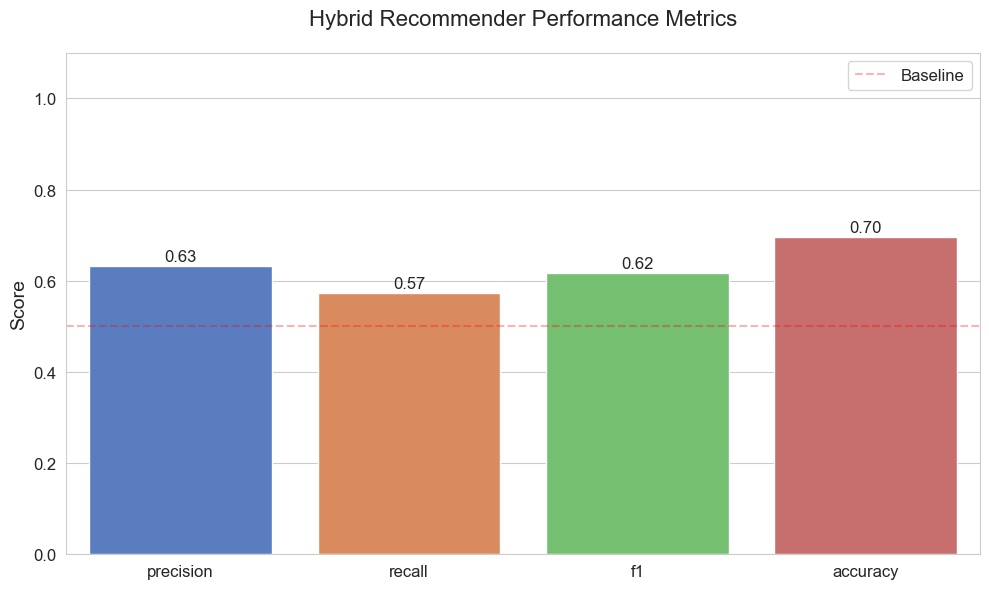

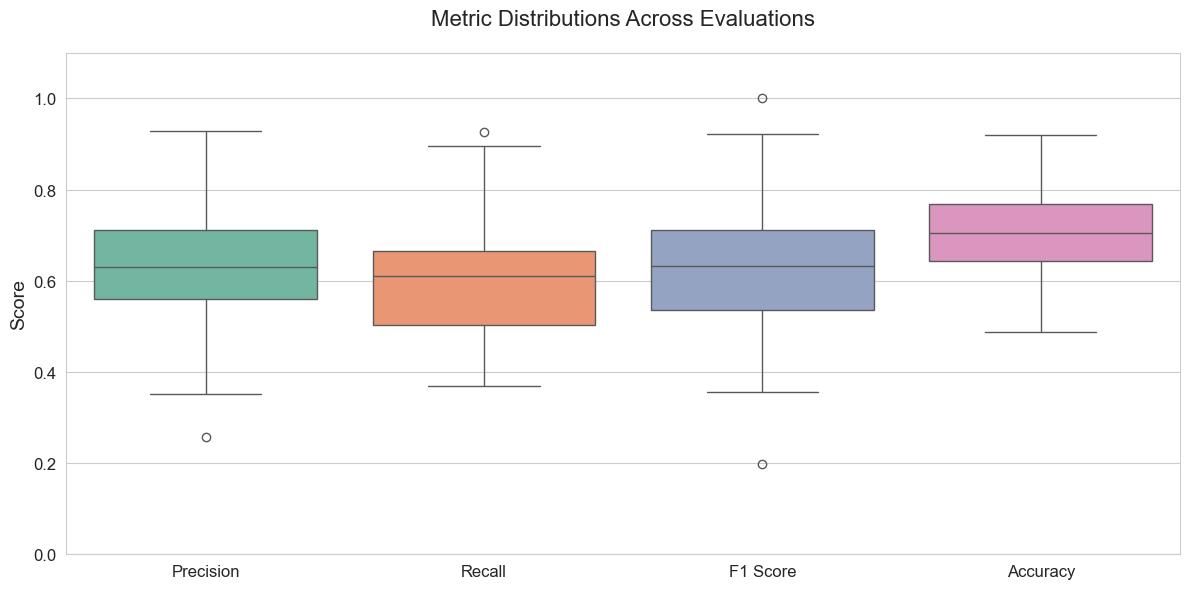

In [11]:
# Your existing code
places_df = load_data("africa_data_with_sentiment.csv")
recommender = HybridRecommender(places_df)

# Create visualizer
visualizer = HybridRecommenderVisualizer(recommender)

# Generate mock metrics (in a real scenario, you'd use actual evaluation)
metrics = visualizer.generate_mock_evaluation()

# Visualize
print("Mock Performance Metrics:")
for metric, score in metrics.items():
    print(f"- {metric.title()}: {score:.3f}")

# Plot the metrics
visualizer.plot_metrics(metrics, save_path="recommender_metrics.png")

# Show metric distributions
visualizer.plot_metric_distribution(save_path="metric_distributions.png")